<a href="https://colab.research.google.com/github/elarroud/DL-Projects/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print('Using PyTorch version:', torch.__version__, 'Device: ', device)

Using PyTorch version: 1.10.0+cu111 Device:  cpu


In [14]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True,
                               transform=transforms.ToTensor())
validation_dataset = datasets.MNIST('./data',
                                    train=False,
                                    download=True,
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

In [15]:
for (X_train,y_train) in train_loader:
  print("X_train:", X_train.size(), "type:", X_train.type())
  print("X_train:", y_train.size(), "type:", y_train.type())
  break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
X_train: torch.Size([32]) type: torch.LongTensor


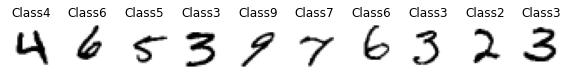

In [16]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))

for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
  plt.title("Class"+str(y_train[i].item()))

In [47]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28,50)
    self.fc1_drop = nn.Dropout(0.2) #Dilution to avoid overfitting
    self.fc2 = nn.Linear(50,50)
    self.fc2_drop = nn.Dropout(0.2)
    self.fc3 = nn.Linear(50,10)
  
  def forward(self, x):
    x = x.view(-1,28*28)
    x = F.relu(self.fc1(x))
    x = self.fc1_drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc2_drop(x)
    return F.log_softmax(self.fc3(x), dim=1)

In [48]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [49]:
def train(epoch, log_interval=200):
  # Set the model to training mode
  model.train() # some layers behave differently in test/train

  # Loop over each batch from the training set
  for batch_idx, (data, target) in enumerate(train_loader):
    # move data to Cuda if necessary
    data = data.to(device)
    target = target.to(device)

    # Zero gradient buffers
    optimizer.zero_grad()

    # Pass the data through the network
    output = model(data)

    # Calculate the loss
    loss=criterion(output, target)

    # Backpropagate
    loss.backward()

    # Update weights
    optimizer.step()

    if batch_idx % log_interval ==0:
      print('Train Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.data.item()
      ))

In [52]:
def validate(loss_vector, accuracy_vector):
  model.eval()
  val_loss, correct = 0, 0
  for data, target in validation_loader:
    data = data.to(device)
    target = target.to(device)

    output = model(data)
    val_loss += criterion(output, target).data.item()
    pred = output.data.max(1)[1] # get th eindex of the maximum log_probability
    correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    print('\nValidation set: Average loss: {:.4f}, Accuracy : {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [53]:
epochs = 3 

lossv, accv = [], []
for epoch in range(1, epochs+1):
  train(epoch)
  validate(lossv, accv)

Train Epoch : 1 [0/60000 (0%)]	Loss: 0.760044
Train Epoch : 1 [6400/60000 (11%)]	Loss: 0.489042
Train Epoch : 1 [12800/60000 (21%)]	Loss: 0.668271
Train Epoch : 1 [19200/60000 (32%)]	Loss: 1.096517
Train Epoch : 1 [25600/60000 (43%)]	Loss: 0.337514
Train Epoch : 1 [32000/60000 (53%)]	Loss: 0.525127
Train Epoch : 1 [38400/60000 (64%)]	Loss: 0.590747
Train Epoch : 1 [44800/60000 (75%)]	Loss: 0.680767
Train Epoch : 1 [51200/60000 (85%)]	Loss: 0.416612
Train Epoch : 1 [57600/60000 (96%)]	Loss: 0.722876

Validation set  : Average loss: 0.0010, Accuracy : 31/10000 (0%)


Validation set  : Average loss: 0.0012, Accuracy : 60/10000 (1%)


Validation set  : Average loss: 0.0009, Accuracy : 89/10000 (1%)


Validation set  : Average loss: 0.0012, Accuracy : 120/10000 (1%)


Validation set  : Average loss: 0.0009, Accuracy : 150/10000 (2%)


Validation set  : Average loss: 0.0008, Accuracy : 180/10000 (2%)


Validation set  : Average loss: 0.0009, Accuracy : 210/10000 (2%)


Validation set  : Aver